In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_csv('/content/insurance2.csv')

# Display the first few rows of the dataset
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values (optional, or you could impute them)
df = df.dropna()

# Separate features and target
X = df.drop(columns=['insuranceclaim'])
y = df['insuranceclaim']

# Preprocess categorical and numerical features
categorical_features = ['sex', 'smoker', 'region']
numerical_features = ['age', 'bmi', 'children', 'charges']

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder())
        ]), categorical_features)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


   age  sex     bmi  children  smoker  region      charges  insuranceclaim
0   19    0  27.900         0       1       3  16884.92400               1
1   18    1  33.770         1       0       2   1725.55230               1
2   28    1  33.000         3       0       2   4449.46200               0
3   33    1  22.705         0       0       1  21984.47061               0
4   32    1  28.880         0       0       1   3866.85520               1
age               0
sex               0
bmi               0
children          0
smoker            0
region            0
charges           0
insuranceclaim    0
dtype: int64


In [4]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Define the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])

# Train the model
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi', 'children',
                                                   'charges']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('classifier',
                 XGBClassifier(base_sc...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       111
           1       0.97      0.99      0.98       157

    accuracy                           0.97       268
   macro avg       0.98      0.97      0.97       268
weighted avg       0.97      0.97      0.97       268

Confusion Matrix:
[[106   5]
 [  2 155]]
ROC AUC Score: 0.9942617777012681


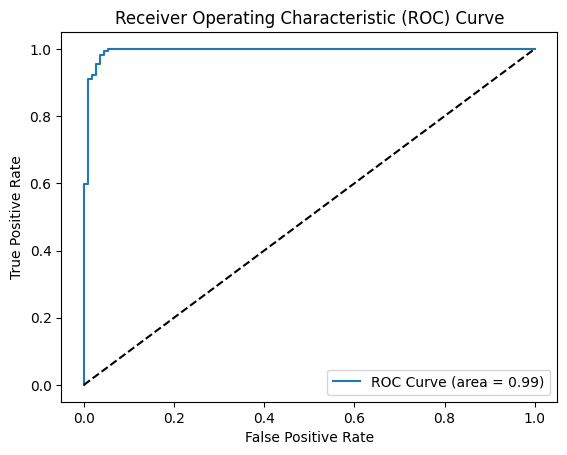

In [5]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc}")

# Plot ROC Curve
import matplotlib.pyplot as plt
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()
